In [1]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

--2019-08-06 15:09:14--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.200.176, 2404:6800:4002:811::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.200.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  3.63MB/s    in 1m 49s  

2019-08-06 15:11:04 (3.57 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

--2019-08-06 15:11:04--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.152.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.152.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py’

In [1]:
!ls

bert_model	       exploration.ipynb  __pycache__
bert-model.ipynb       modeling.py	  run_classifier.py
Dataset		       new_dataset	  tokenization.py
embedding-layer.ipynb  optimization.py	  uncased_L-12_H-768_A-12.zip


In [1]:
import modeling
import optimization
import run_classifier
import tokenization


import zipfile
folder = 'bert_model'
# with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
#     zip_ref.extractall(folder)


BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')



>> Model output directory: bert_model/outputs
>>  BERT pretrained directory: bert_model/uncased_L-12_H-768_A-12


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gc, os
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

In [18]:
# train = pd.read_csv('Dataset/train.csv')
# test  = pd.read_csv('Dataset/test.csv')
# sub   = pd.read_csv('Dataset/Sample_Submission.csv')
# df    = train.append(test,ignore_index=True)

# train.shape, test.shape, sub.shape, df.shape

((5959, 3), (2553, 2), (5, 3), (8512, 3))

In [21]:
# import string
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
# punc = string.punctuation

# df['word_count']   = df['Review Text'].apply(lambda x: len(str(x).split(" ")))
# df['char_count']   = df['Review Text'].apply(len)
# df['word_density'] = df['char_count'] / (df['word_count']+1)
# df['stopw_count']  = df['Review Text'].apply(lambda x: len([w for w in x.split() if w in stop]))
# df['punc_count']   = df['Review Text'].apply(lambda x: len("".join(_ for _ in x if _ in punc)))
# df['num_count']    = df['Review Text'].apply(lambda x: len([w for w in x.split() if w.isdigit()]))

# df.shape

(8512, 9)

In [12]:
train['Review Text'][0].split(" ")[:9]

['Did', 'nothing', 'for', 'me,', "didn't", 'help', 'lost', 'even', 'with']

In [3]:
train = pd.read_csv('new_dataset/train.csv')
test  = pd.read_csv('new_dataset/test.csv')
train.shape, test.shape

((5959, 3), (2553, 2))

In [4]:
train.columns

Index(['text', 'title', 'topic'], dtype='object')

In [5]:
train['target'] = train['topic'].astype('category').cat.codes

In [6]:
from scipy.sparse import csr_matrix
from scipy import sparse
# final_features = sparse.hstack((df_train[col],train_vectorized )).tocsr()
# final_featurest = sparse.hstack((df_test[col],test_vectorized )).tocsr()


from keras.utils import to_categorical
target = train.target.values
y      = to_categorical(target)
print(y.shape)


from sklearn.model_selection import train_test_split
X_train , X_val , Y_train , Y_val = train_test_split(
    train['text'], y,test_size = 0.20)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

Using TensorFlow backend.


(5959, 21)
(4767,) (1192,) (4767, 21) (1192, 21)


In [7]:
word_len = train['text'].apply(lambda x: len(str(x).split(" ")))
word_len.shape

(5959,)

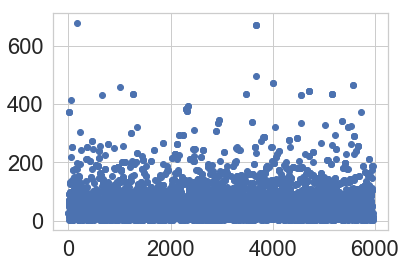

In [11]:
plt.scatter(range(len(word_len)), word_len)

In [12]:
def get_quantile(df, col, q1, q2):
    """compute quantile range
    args:
        col: col name
        q1: lower quantile percentile
        q2: upper quantile percentile
    """
    df1 = df[[col]].dropna()
    lower_bound = np.percentile(df1, q=q1)
    upper_bound = np.percentile(df1, q=q2)
    lower_bound = np.round(lower_bound,3)
    upper_bound = np.round(upper_bound, 3)
    min_ = np.round(np.min(df1[col]), 3)
    max_ = np.round(np.max(df1[col]), 3)
    print("Col: {4:<10} min: {0:<10} max: {1:<10} low: {2:<10} high: {3:<10}".format(min_, max_, lower_bound, upper_bound, col))

train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
get_quantile(train, 'word_count', 1, 95)
get_quantile(train, 'word_count', 1, 96)
get_quantile(train, 'word_count', 1, 97)
get_quantile(train, 'word_count', 1, 98)
get_quantile(train, 'word_count', 1, 99)

Col: word_count min: 1          max: 678        low: 3.0        high: 175.0     
Col: word_count min: 1          max: 678        low: 3.0        high: 188.0     
Col: word_count min: 1          max: 678        low: 3.0        high: 208.0     
Col: word_count min: 1          max: 678        low: 3.0        high: 244.84    
Col: word_count min: 1          max: 678        low: 3.0        high: 302.0     


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping,ReduceLROnPlateau


tokenizer = Tokenizer(num_words=50000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(list(X_train))

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)


max_features = len(word_index) + 1
max_words    = 200#302
batch_size   = 16
epochs       = 10
num_classes  = 21

# X_test = tokenizer.texts_to_sequences(df_test['text'])
# X_test = pad_sequences(X_test, maxlen=max_words)

X_train = pad_sequences(X_train, maxlen = max_words)
X_val   = pad_sequences(X_val, maxlen   = max_words)

X_train.shape, X_val.shape

((4767, 200), (1192, 200))

In [9]:

from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim






def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples




In [10]:
import tensorflow as tf

# Model Hyper Parameters
TRAIN_BATCH_SIZE  = 16
EVAL_BATCH_SIZE   = 32
LEARNING_RATE     = 1e-5
NUM_TRAIN_EPOCHS  = 10
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH    = 100
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES   = 8
VOCAB_FILE      = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE     = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE   = BERT_MODEL.startswith('uncased')


label_list = list(range(21))
tokenizer  = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case = DO_LOWER_CASE)
train_examples = create_examples(train["text"].values, 'train', labels = train["target"].values.astype(int))

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster                = tpu_cluster_resolver,
    model_dir              = OUTPUT_DIR,
    save_checkpoints_steps = SAVE_CHECKPOINTS_STEPS,
    tpu_config             = tf.contrib.tpu.TPUConfig(
        iterations_per_loop = ITERATIONS_PER_LOOP,
        num_shards          = NUM_TPU_CORES,
        per_host_input_for_training = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))



num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config     = modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels      = len(label_list),
    init_checkpoint = INIT_CHECKPOINT,
    learning_rate   = LEARNING_RATE,
    num_train_steps = num_train_steps,
    num_warmup_steps= num_warmup_steps,
    use_tpu         = False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)


estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu          = False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn         = model_fn,
    config           = run_config,
    train_batch_size = TRAIN_BATCH_SIZE,
    eval_batch_size  = EVAL_BATCH_SIZE)




INFO:tensorflow:Using config: {'_model_dir': 'bert_model/outputs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbe32c48e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=100000, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed_sleep_secs=None), '_cluster': None}
INFO:tensorflow:_TPUContext: eval_on_tpu True


In [11]:
num_classes = 21
label_dict = {}
for i in range(num_classes):
    label_dict[str(i)] = i

# {'0':0,'1':1,'2':2}

import datetime
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(train_examples,label_dict, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features       = train_features,
    seq_length     = MAX_SEQ_LENGTH,
    is_training    = True,
    drop_remainder = True)
estimator.train(input_fn = train_input_fn, max_steps = num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))


Please wait...
INFO:tensorflow:Writing example 0 of 5959
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train
INFO:tensorflow:tokens: [CLS] did nothing for me , did not help lost even with working out and eating healthy . did not curb appetite or anything . [SEP]
INFO:tensorflow:input_ids: 101 2106 2498 2005 2033 1010 2106 2025 2393 2439 2130 2007 2551 2041 1998 5983 7965 1012 2106 2025 13730 18923 2030 2505 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:  name = bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:te

INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/

INFO:tensorflow:  name = bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I

In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    all_input_ids   = []
    all_input_mask  = []
    all_segment_ids = []
    all_label_ids   = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.segment_ids)
        all_label_ids.append(feature.label_id)

    def input_fn(params):
        """The actual input function."""
        print(params)
        batch_size = 500

        num_examples = len(features)

        d = tf.data.Dataset.from_tensor_slices({
            "input_ids":
                tf.constant(
                    all_input_ids, shape=[num_examples, seq_length], dtype=tf.int32),
            "input_mask":
                tf.constant(
                    all_input_mask, shape=[num_examples, seq_length], dtype=tf.int32),
            "segment_ids":
                tf.constant(
                    all_segment_ids, shape=[num_examples, seq_length], dtype=tf.int32),
            "label_ids":
                tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
        })

        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
        return d

    return input_fn

    
# predict_examples = create_examples(df_test['text'].values, 'test')

# predict_features = run_classifier.convert_examples_to_features(
# predict_examples, {'0':0,'1':1,'2':2}, MAX_SEQ_LENGTH, tokenizer)

# predict_input_fn = input_fn_builder(
#     features       = predict_features,
#     seq_length     = MAX_SEQ_LENGTH,
#     is_training    = False,
#     drop_remainder = False)

# result = estimator.predict(input_fn=predict_input_fn)

# preds = []
# for prediction in result:
#     preds.append(np.argmax(prediction['probabilities']))


In [16]:
predict_examples = create_examples(test['text'].values, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_dict, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features       = predict_features,
    seq_length     = MAX_SEQ_LENGTH,
    is_training    = False,
    drop_remainder = False)

INFO:tensorflow:Writing example 0 of 2553
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] use chi ##a seed in my protein shakes . these tasted like they were mold ##y . throw them out [SEP]
INFO:tensorflow:input_ids: 101 2224 9610 2050 6534 1999 2026 5250 10854 1012 2122 12595 2066 2027 2020 18282 2100 1012 5466 2068 2041 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:la

ValueError: Unsupported string type: <class 'float'>

In [20]:
tokenizer  = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case = DO_LOWER_CASE)
predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_dict, MAX_SEQ_LENGTH, tokenizer)


INFO:tensorflow:Writing example 0 of 2553
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] use chi ##a seed in my protein shakes . these tasted like they were mold ##y . throw them out [SEP]
INFO:tensorflow:input_ids: 101 2224 9610 2050 6534 1999 2026 5250 10854 1012 2122 12595 2066 2027 2020 18282 2100 1012 5466 2068 2041 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:la

ValueError: Unsupported string type: <class 'float'>

In [23]:
test['text'].values

array([' use chia seed in my protein shakes . these tasted like they were moldy . throw them out',
       ' use chia seed in my protein shakes . these tasted like they were moldy . throw them out',
       'do not waste your money . ', ...,
       'very small and easy to swallow - no flavor at all - but left me with my stomach in knots / horrible bloating each time tried taking it . will not be purchasing again . ',
       'good but it increases the bad cholesterol - ldl . < br / > it does not suite me . ',
       'will not buy the powder again . '], dtype=object)